# Variational AutoEncoder Code
This notebook is an implementation of a variational auto-encoder which was taken from https://blog.lancedb.com/training-a-variational-autoencoder-from-scratch-with-the-lance-file-format/


In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import io

from PIL import Image
from tqdm import tqdm


from matplotlib import pyplot as plt

import requests
import tarfile
import os
import time

import pyarrow as pa
import lance


### Variational Autoencoder Configuration Breakdown
BATCH_SIZE:
- The number of samples processed together in one forward/backward pass before updating weights

IN_RESOLUTION:
- Input image resolution (width & height)

IN_CHANNELS: 
- Number of channels in the input
-- For RGB images->3 channels
-- For greyscale->1 channel

NUM_EPOCHS:
- Number of full passes through the dataset during training
- Higher epoch -> more opportunities for the model to converge

LEARNING_RATE: 
- Step size used by the optimiser to adjust wieghts
- Smaller -> more stable training but slower
- Larger -> faster, but may overshoot

HIDDEN_DIMS: 
- Defines the number of feature maps in each convolutional layer of the encoder/decoder
- Controls capacity & compression power. eg:
Layer 1: 64 filters
Layer 2: 128 filters
Layer 3: 256 filters
Layer 4: 512 filters

LATENT_DIM_SIZE: 
- Size of the latent space (bottleneck vector)
- size may depend on the image training data size

In [ ]:
vae_config = {
    "BATCH_SIZE": 512,
    "IN_RESOLUTION": 310,
    "IN_CHANNELS": 3,
    "NUM_EPOCHS": 100,
    "LEARNING_RATE": 1e-4,
    "HIDDEN_DIMS": [64, 128, 256, 512],
    "LATENT_DIM_SIZE": 64,
}

### Utility function to visualise generated data.

In [3]:
def draw_image_grid(samples):
    images = samples[:4]
    images = (images * 0.5) + 0.5  # Unnormalize the images to [0, 1] range
    grid_img = torchvision.utils.make_grid(images, nrow=2)
    plt.figure(figsize=(5, 5))
    plt.imshow(grid_img.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    plt.axis('off')
    plt.show()

In [4]:
class CustomImageDataset(data.Dataset):
    def __init__(self, classes, lance_dataset, transform=None):
        self.classes = classes
        self.ds = lance.dataset(lance_dataset)
        self.transform = transform

    def __len__(self):
        return self.ds.count_rows()

    def __getitem__(self, idx):
        raw_data = self.ds.take([idx], columns=['image', 'label']).to_pydict()
        img_data, label = raw_data['image'][0], raw_data['label'][0]

        img = Image.open(io.BytesIO(img_data))

        # Convert grayscale images to RGB
        if img.mode != 'RGB':
            img = img.convert('RGB')

        if self.transform:
            img = self.transform(img)

        label = self.classes.index(label)
        return img, label

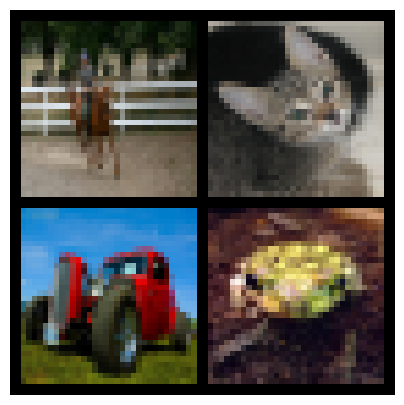

In [ ]:
train_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # -1 to 1
    ]
)
classes = ('cat')

lance_train_dataset = CustomImageDataset(
    classes,
    "cat-spectrograms/cat-spectrograms_train.lance/",
    transform=train_transform
)

lance_train_loader = torch.utils.data.DataLoader(
    lance_train_dataset,
    batch_size=vae_config["BATCH_SIZE"],
    shuffle=True
)

images, _ = next(iter(lance_train_loader))
draw_image_grid(images)

### VAE Class Defintion 

In [6]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(vae_config["IN_CHANNELS"], 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )

        self.fc_mu = nn.Linear(128*4*4, vae_config["LATENT_DIM_SIZE"])
        self.fc_logvar = nn.Linear(128*4*4, vae_config["LATENT_DIM_SIZE"])

        # Decoder
        self.decoder_input = nn.Linear(vae_config["LATENT_DIM_SIZE"], 128*4*4)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, vae_config["IN_CHANNELS"], kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # Output values in range [-1, 1]
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        z = self.decoder_input(z)
        z = z.view(-1, 128, 4, 4)
        return self.decoder(z), mu, logvar

    def sample(self, num_samples):
        z = torch.randn(num_samples, vae_config["LATENT_DIM_SIZE"]).to(device)
        return self.decoder(self.decoder_input(z).view(-1, 128, 4, 4))

### Training the data

In [7]:
device = "cpu" #change to "cuda" if you have an NVIDIA CPU

# Loss Function
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

# Initialize model, optimizer
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=vae_config["LEARNING_RATE"])

Epoch 1/100: 100%|██████████| 22/22 [04:35<00:00, 12.53s/it, Loss=3.03e+6]

Epoch [1/100] Average Loss: 760.7629


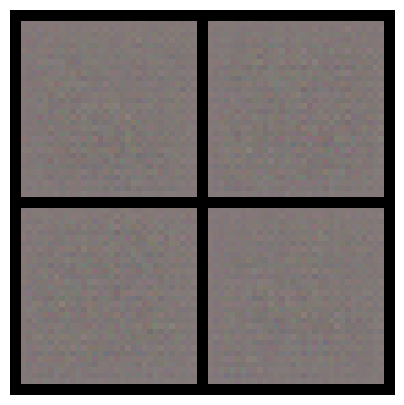

Epoch 2/100: 100%|██████████| 22/22 [04:03<00:00, 11.07s/it, Loss=2.76e+6]


Epoch [2/100] Average Loss: 728.9694


Epoch 3/100: 100%|██████████| 22/22 [04:12<00:00, 11.49s/it, Loss=2.5e+6] 


Epoch [3/100] Average Loss: 648.4656


Epoch 4/100: 100%|██████████| 22/22 [04:20<00:00, 11.82s/it, Loss=2.28e+6]


Epoch [4/100] Average Loss: 594.4620


Epoch 5/100: 100%|██████████| 22/22 [03:54<00:00, 10.67s/it, Loss=2.06e+6]


Epoch [5/100] Average Loss: 544.5268


Epoch 6/100: 100%|██████████| 22/22 [03:55<00:00, 10.70s/it, Loss=1.78e+6]


Epoch [6/100] Average Loss: 476.6725


Epoch 7/100: 100%|██████████| 22/22 [08:32<00:00, 23.31s/it, Loss=1.63e+6]


Epoch [7/100] Average Loss: 427.4915


Epoch 8/100: 100%|██████████| 22/22 [04:33<00:00, 12.41s/it, Loss=1.57e+6]


Epoch [8/100] Average Loss: 400.6129


Epoch 9/100: 100%|██████████| 22/22 [05:25<00:00, 14.81s/it, Loss=1.51e+6]


Epoch [9/100] Average Loss: 382.6578


Epoch 10/100: 100%|██████████| 22/22 [05:36<00:00, 15.30s/it, Loss=1.44e+6]


Epoch [10/100] Average Loss: 368.7986


Epoch 11/100: 100%|██████████| 22/22 [05:46<00:00, 15.73s/it, Loss=1.42e+6]

Epoch [11/100] Average Loss: 357.9826


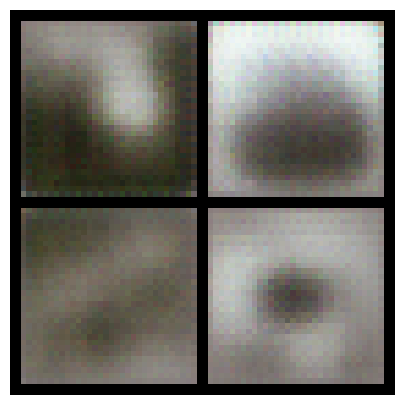

Epoch 12/100: 100%|██████████| 22/22 [05:45<00:00, 15.69s/it, Loss=1.38e+6]


Epoch [12/100] Average Loss: 349.2064


Epoch 13/100: 100%|██████████| 22/22 [05:28<00:00, 14.94s/it, Loss=1.36e+6]


Epoch [13/100] Average Loss: 341.6100


Epoch 14/100: 100%|██████████| 22/22 [05:39<00:00, 15.42s/it, Loss=1.32e+6]


Epoch [14/100] Average Loss: 334.6677


Epoch 15/100: 100%|██████████| 22/22 [05:35<00:00, 15.26s/it, Loss=1.3e+6] 


Epoch [15/100] Average Loss: 328.2411


Epoch 16/100: 100%|██████████| 22/22 [04:36<00:00, 12.56s/it, Loss=1.29e+6]


Epoch [16/100] Average Loss: 322.3681


Epoch 17/100: 100%|██████████| 22/22 [25:59<00:00, 70.87s/it, Loss=1.25e+6] 


Epoch [17/100] Average Loss: 317.0683


Epoch 18/100: 100%|██████████| 22/22 [04:14<00:00, 11.59s/it, Loss=1.24e+6]


Epoch [18/100] Average Loss: 312.3902


Epoch 19/100: 100%|██████████| 22/22 [04:14<00:00, 11.59s/it, Loss=1.21e+6]


Epoch [19/100] Average Loss: 307.6008


Epoch 20/100: 100%|██████████| 22/22 [04:08<00:00, 11.31s/it, Loss=1.2e+6] 


Epoch [20/100] Average Loss: 302.4250


Epoch 21/100:  18%|█▊        | 4/22 [00:55<04:09, 13.86s/it, Loss=1.22e+6]


KeyboardInterrupt: 

In [8]:
for epoch in range(vae_config["NUM_EPOCHS"]):
    model.train()
    train_loss = 0

    # Use tqdm for the progress bar
    pbar = tqdm(enumerate(lance_train_loader), total=len(lance_train_loader), desc=f'Epoch {epoch+1}/{vae_config["NUM_EPOCHS"]}')

    for batch_idx, (data, _) in pbar:
        data = data.to(device)

        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        # Update tqdm description with current loss
        pbar.set_postfix({'Loss': loss.item()})

    avg_loss = train_loss / len(lance_train_loader.dataset)
    print(f'Epoch [{epoch + 1}/{vae_config["NUM_EPOCHS"]}] Average Loss: {avg_loss:.4f}')

    # show and display a sample of the reconstructed images
    if epoch % 10 == 0:
        with torch.no_grad():
            sampled_images = model.sample(num_samples=4)
            draw_image_grid(recon_batch.cpu())

### The Reconstructed Images

In [ ]:
images, _ = next(iter(lance_train_loader))
draw_image_grid(images)

In [ ]:
with torch.no_grad():
    recon_images, _, _ = model(images.to(device))
draw_image_grid(recon_images.cpu())